# **Cognition & Computation  final project**
## *Matteo Zandegiacomo Orsolina*
### 2053843

# Preprocessing

As a first thing, a function is defined in order to download the script of two functions that are going to be used: the Deep Belief Network (DBN) and the Restricted Boltzman Machine (RBM), the second being the building blocks to create the DBN itself. Such functions use the library PyTorch in order to build the network.

In [289]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [290]:
%%capture
get_dbn_library()

In [291]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
from tqdm.notebook import tqdm
import torch.nn.functional as functional
import PIL
from DBN import DBN

If a GPU is available, it helps doing all the computations in a faster way, so the used device is chosen to be a GPU. In case it is not available, the CPU is used in its place. This is pretty relevant, since training a DBN using only the CPU could require a lot of time.

In [292]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


Both the training and the test sets of the EMNIST dataset are downloaded. Just the EMNIST part of the database containing only letters is used. 145600 handwritten letters are thus downloaded in the two sets.
All the elemnts are also transformed, in order to simplify further computations. First of all, all the images are transformed to a PyTorch tensor, and afterwards they are normalized, in such a way that the Pixel values stay in the interval [0,1], by dividing each pixel by 255.

In [293]:
%%capture
emnist_train = tv.datasets.EMNIST('data/', train=True, download=True, split = 'letters',
                                 transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

emnist_test = tv.datasets.EMNIST("data/", train=False, download=True, split = 'letters',
                                transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

In [294]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

Through the use of a dictionary, a map is created that helps to connect the numerical values used in the target both of the training and test data, to the corresponding letter. 

In [295]:
emnist_map = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R',
              19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}


An example of an element is shown here. The raw 28x28 pixels can be seen. Through the mapping it is possible to confirm that the target is indeed right. The image is also flipped horizontally and then rotated, in order to be able to see the letter as we would read it, since by default it wouldn't be like that.

The digit shown is the value: K


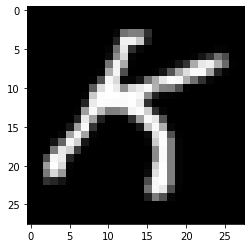

In [296]:
idx = 7
img = emnist_train.data[idx]
print("The digit shown is the value: {}".format(emnist_map[int(emnist_train.targets[idx])]))
plt.imshow(tv.transforms.functional.hflip(img.rot90(k = 3)), cmap = 'gray')
plt.show()

The data and corresponding targets in both train and test set are moved from the CPU to the GPU (if available)

In [297]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)

In [298]:
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

# DBN

A DBN object is defined, using the DBN class that was previously imported. Follows a brief description of the hyperparameters:
* 28x28 is the number of visible units, that is the number of input nodes of the network, which corresponds to the size of a single image in pixels;
* The list of hidden units represents the number of nodes in each of the layers that are going to form the network. In particular, the first layer is going to have 400 nodes, the second 500, the last one 800;
* k is the number of contrastive divergence (CD) steps that should be performed during training. CD is an algorithm used to train an RBM, used to update the weights of the RBM itself;
* The learning rate determines how fast the weights are updated at each iteration;
* A decadence of the learning rate has been put to false, so the learning rate doesn't decrease over time;
* The momentum used at the beginning of the training, in order to speed it up, giving a fraction of the previous weight update to the new one as well;
* The momentum used in the final stages of training, when we are close to the final result, so it gets smaller for a better convergence;
* A weight decay factor penalizes big weights, making them decrease;
* The Xavier Initialization is not used in this case;
* The number of k is kept constant over the whole training;
* If available, a GPU is used, instead of the CPU.

In [299]:
dbn_emnist = DBN(visible_units=28*28, hidden_units=[400, 500, 800], k=1, learning_rate=0.1, learning_rate_decay=False,
                initial_momentum=0.5, final_momentum=0.9, weight_decay=0.0001, xavier_init=False, increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

The network is trained, splitting at each epoch the data in a number of batches.
For each layer, every 10 epochs the reconstruction error is printed. The reconstruction error measures the difference between the original data and its reconstructed version. For each layer, the reconstruction error decreases, on average, with the epochs. The values mean_grad and std_grad represents the magnitude and the variation of the gradient. Such values shouldn't be too big nor too small, since there need to be an improvement, but if that improvement is too big it would make us miss the optimal point.

In [300]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(emnist_train.data, emnist_train.targets, num_epochs, batch_size)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2658     |0.0411       |269.5267   |5.4690     |
|20    |1.2095     |0.0378       |255.2362   |5.1828     |
|30    |1.1914     |0.0376       |249.8972   |4.8837     |
|40    |1.1807     |0.0368       |247.1100   |4.8349     |
|50    |1.1768     |0.0371       |245.2681   |4.9324     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.6336     |0.0411       |188.8642   |3.3693     |
|20    |1.5681     |0.0387       |184.4152   |3.0903     |
|30    |1.5560     |0.0389       |182.7169   |2.8649     |
|40    |1.5491     |0.0409       |181.8221   |3.3176     |
|50    |1.5461     |0.0395       |181.8195   |2.8727     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1677     |0.0316       |223.0824   |4.1201     |
|20    |1.0782     |0.0303       |212.4715   |3.878

## Visualizing receptive fields

After training the network, we are now going to visualize the learned weights. In order to do so, we will plot some of the weights in a picture of the same size of the EMNIST images we used for training. In this way, it is possible to see which parts of an image trigger the unit associated with a specific weight vector. A threshold is applied in order to make the plots less noisy, and all the values in different weights are scaled in the same way, in order to make a comparison easier.
The first 100 filters learned in each layer are represented, showing what part of the image or what pattern that particular node is able to recognize. Since in second and third layer the dimensionality is different, it is necessary to project each one of them in a space of the right 28x28 dimensions space.

In [301]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

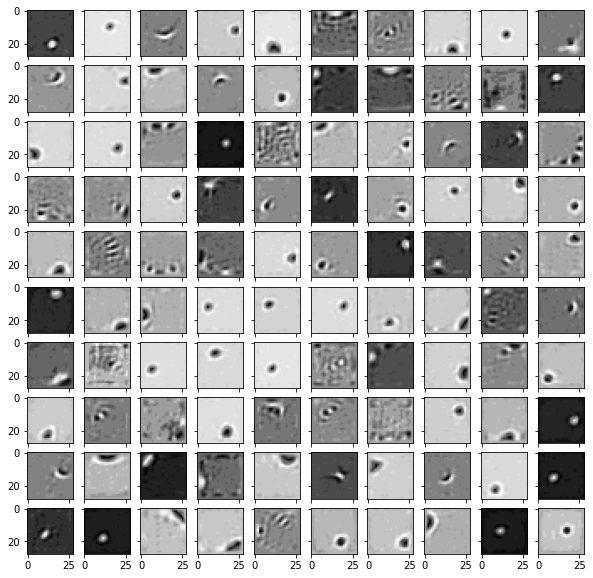

In [302]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

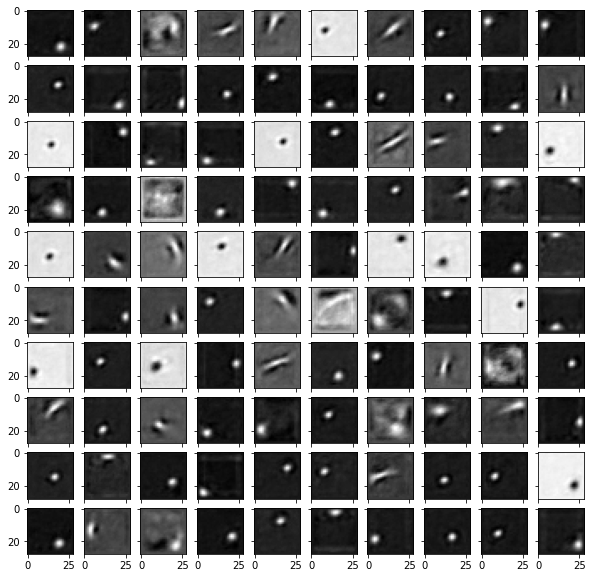

In [303]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

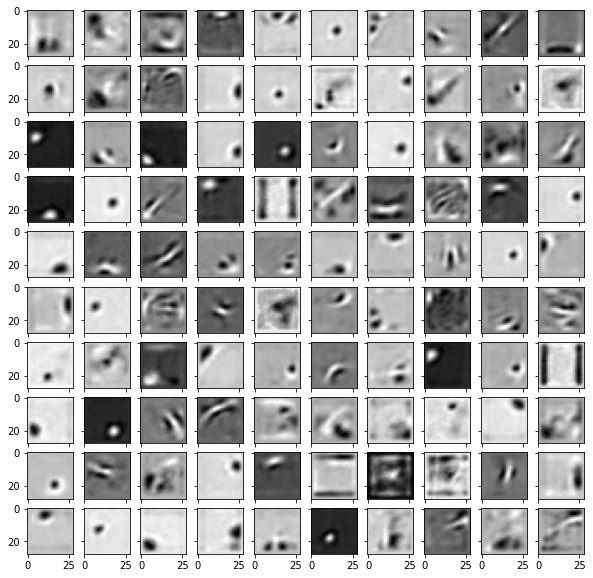

In [304]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

## Clustering internal representations

Then, we compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.
This implementation of the DBN contains internally several RBM objects. Therefore, we will need to compute the hidden representation using the weights of each RBM layer contained in the DBN. In particular, the representations of the second layer is computed using the representation of the previous one, and so on.

In [305]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [306]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

What we try to do now is to compute the mean hidden representation for each class in the EMNIST dataset, and build a matrix of that representations, containing all the centroids required.
The matrix that we obtain is going to be 26xD, where D is the number of nodes in that layer. In particular, for the third layer the matrix is going to be 26x800.

In [307]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(1,27)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(1,27)])

In [310]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)

In [311]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)

In [308]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.
Finally it is possible to use a clustering algorithm and visualize the output in a dendrogram, which shows how the points are grouped into clusters at the various levels.
The dendrogram is very useful in such problems, since it can show very easily that some classes are very close to one another, while others are pretty far away, and it is very unlickely that one of them may be confused for another one.

The dendrogram of each one of the three layers is plotted and it shows the fact that each layer creates different clusterings, according to the features that are considered. The differences are not very obvious, because partly it's the layout that make it look as they are different, but if we go check all the branches, we notice some difference. For example, very similar letters, like G and Q, I and L, P and F, are always close to each others, but for example the branching around W and M is slightly different.

In [309]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=[emnist_map[i+1] for i in range(26)])
  ax.set_title(title)

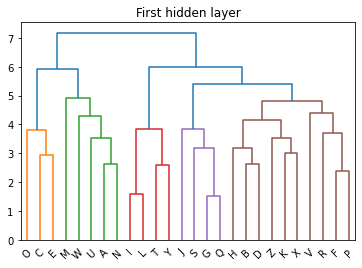

In [312]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

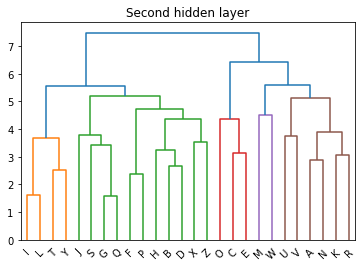

In [313]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

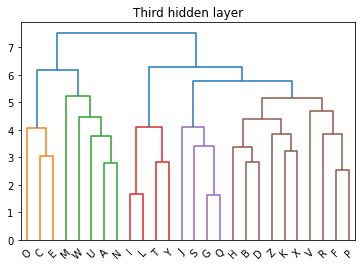

In [314]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Linear read-out

Now a linear readout of the representations computed by the DBN at each layer is made. The representations are going to be used in order to classify the original images with a simple linear classifier, as a way to assess how much information is contained in each hidden representatation. 
In order to do so, a class is defined, containing a function that linearly transforms the input tensor, thanks to a single fully connected layer. \\
A linear model is going to be computed for each layer of the DBN.

In [315]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 27)

  def forward(self, x):
    return self.linear(x)

In [316]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

A linear classifier is defined, taking as input the hidden representations of each layer previously computed, and it works using the labels of the EMNIST dataset as targets. A stochastic gradient descent is used as the optimizer in this model, being calculated every time with the particular batch. \\
Each linear layer is going to be trained this way, and it is possible to see that the loss (a cross-entropy, for instance) decreses with the epochs on each one of the three layers. If a choice was made to make the model train for even more epochs, the final loss would have been smaller, but in order to avoid overfitting, and also due to the fact that the improvement of the loss was slowing down, a decision to cut it off after 1500 was taken.

In [317]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1500

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [318]:
train_linear(linear1, hidden_repr_layer_1)

epoch :   1/1500, loss = 3.3682
epoch : 101/1500, loss = 2.1098
epoch : 201/1500, loss = 1.6693
epoch : 301/1500, loss = 1.4657
epoch : 401/1500, loss = 1.3487
epoch : 501/1500, loss = 1.2708
epoch : 601/1500, loss = 1.2140
epoch : 701/1500, loss = 1.1698
epoch : 801/1500, loss = 1.1340
epoch : 901/1500, loss = 1.1040
epoch : 1001/1500, loss = 1.0784
epoch : 1101/1500, loss = 1.0561
epoch : 1201/1500, loss = 1.0364
epoch : 1301/1500, loss = 1.0188
epoch : 1401/1500, loss = 1.0030


In [319]:
train_linear(linear2, hidden_repr_layer_2)

epoch :   1/1500, loss = 3.3182
epoch : 101/1500, loss = 2.0576
epoch : 201/1500, loss = 1.6422
epoch : 301/1500, loss = 1.4544
epoch : 401/1500, loss = 1.3463
epoch : 501/1500, loss = 1.2739
epoch : 601/1500, loss = 1.2207
epoch : 701/1500, loss = 1.1791
epoch : 801/1500, loss = 1.1453
epoch : 901/1500, loss = 1.1169
epoch : 1001/1500, loss = 1.0925
epoch : 1101/1500, loss = 1.0712
epoch : 1201/1500, loss = 1.0524
epoch : 1301/1500, loss = 1.0355
epoch : 1401/1500, loss = 1.0202


In [320]:
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 3.3340
epoch : 101/1500, loss = 2.0110
epoch : 201/1500, loss = 1.5717
epoch : 301/1500, loss = 1.3740
epoch : 401/1500, loss = 1.2601
epoch : 501/1500, loss = 1.1837
epoch : 601/1500, loss = 1.1273
epoch : 701/1500, loss = 1.0832
epoch : 801/1500, loss = 1.0471
epoch : 901/1500, loss = 1.0168
epoch : 1001/1500, loss = 0.9908
epoch : 1101/1500, loss = 0.9680
epoch : 1201/1500, loss = 0.9478
epoch : 1301/1500, loss = 0.9297
epoch : 1401/1500, loss = 0.9133


Now the test set is considered. First of all the hidden representation of the three layers on this set is computed. Then a prediction is done, using the model that was previously trained. \\
In order to check if this linear model actually works, an accuracy score is computed. The values obtained on all of the layers are around 0.7. Such a value seems reasonable, since it is closer to 1, so a good proportion of the predictions were actually right. \\
Being the model trained using a stochastic gradient optimizer, it is important to underline that the final results are going to depend very much on the run. The layers are going to perform differently, but according to a few tests I have done, the final accuracy should stay in the range [0.71, 0.76] with a good probability. If we had left the model train for more epochs, we would have achieved better results, but doubling the number of epochs would increase only slighty the accuracy.

It is also relevant to notice that the last layer gives a better accuracy than the previous ones, even if, all in all, it doesn't change much.

In [321]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [322]:
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [323]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [324]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.7221153974533081

In [325]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.7158173322677612

In [326]:
compute_accuracy(predictions_test3, emnist_test.targets)

0.7458173036575317

## Feed-forward model

A simple feed-forward neural network with the same structure of the DBN is now trained, in order to compare a non-linear model that is trained end-to-end to solve a classification task with a simple linear classifier which is able to solve the same task using representations of input data learned in an unsupervised way. \\
The feed-forward network which has been built, has three layers, the first one taking an input of the size of 784, that is the number of pixels in an EMNIST image. \\
The same function is used to train the model, with a same number of epochs, and the number of nodes in each layer is the same as before, in order to make the comparison fair. \\
The FFN needs an enormous time to train, while the DBN was pretty fast in comparison. This may be explained, in the first place, by the fact that DBNs use the hidden representation, in which the features have already been extracted and trained layer by layer, making faster to initialize the weights. In addition, the algorithm used by DBN to fine-tune the network is more efficient.

In [88]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 27)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [327]:
ffnn = Feedforward(400, 500, 800).to(device)

In [328]:
train_linear(ffnn, emnist_train.data.reshape((124800, 784)))

epoch :   1/1500, loss = 3.2954
epoch : 101/1500, loss = 3.2554
epoch : 201/1500, loss = 3.1184
epoch : 301/1500, loss = 2.4245
epoch : 401/1500, loss = 1.7680
epoch : 501/1500, loss = 1.4889
epoch : 601/1500, loss = 1.3425
epoch : 701/1500, loss = 1.2434
epoch : 801/1500, loss = 1.1732
epoch : 901/1500, loss = 1.1009
epoch : 1001/1500, loss = 1.0429
epoch : 1101/1500, loss = 0.9900
epoch : 1201/1500, loss = 0.9395
epoch : 1301/1500, loss = 0.8917
epoch : 1401/1500, loss = 0.8468


In [329]:
predictions_ffnn = ffnn(emnist_test.data.reshape((20800, 784)))

In [330]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.7654807567596436

## Robustness to noise

Some noise is now injected in the input images, in order to check if the representations learned by the two networks are robusts to such perturbations in the sensory signal. Clearly, the more the noise, the less the model is going to be able to give a correct result.

A random gaussian noise with the same shape as the input data is generated, and it is multiplied by the noise level, which is a measure of the variance of the gaussian that is computed.

In [331]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

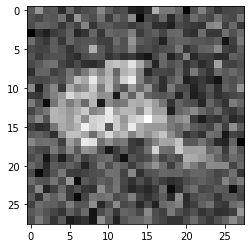

In [332]:
noise_level = 0.3
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(tv.transforms.functional.hflip(emnist_test_with_noise[0].rot90(k = 3)).reshape(28, 28).to("cpu"), cmap="gray")

The hidden representations of the noisy images is finally computed using the DBN, and the same models previously trained are now going to be used in order to classify these new stimuli. First the DBN and then the FFN are going to classify the noisy images, giving the corrispondng accuracy. 

In general, the third layer of the DBN is going to give the best result, but it may vary very much on the run. A bigger sample of cases should be analyised in order to understand whether the DBN or the FFN is the best option.

In [333]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)
  
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [334]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.684
Accuracy of H2 read-out: 0.702
Accuracy of H3 read-out: 0.734
Accuracy of FF network : 0.719


The psychometric curve is now created, at different levels of internal representation, for the three layers of the DBN and for the FFN. This is done in order to notice how the behaviour of the model varies when addidng different amounts of noise. \\
In this particular run, it can be seen that the FNN is the best model when there is very little noise, but when it increases, its performance gets worse and worse. The third RBM is the one that gives the best results on average, and in particular it can be noticed that its results are the best as soon as we pass a noise level value of 0.2.

In [335]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

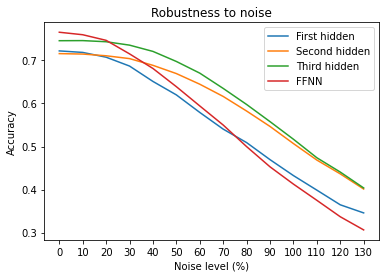

In [336]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

## Adversarial attacks

### Fast gradient sign method

Adversarial attacks tries to modify the input so that the model cannot correctly classify it anymore, making the loss for that particular input increase. The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$. When training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure: 
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

A function is created in order to introduce this FGSM. An image is given in input with the magnitude of the perturbation that we want to introduce, with also the gradient of the loss function.

In [337]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

A read-out classifier is defined, which takes in input the DBN classifier previously defined. The set of pre-trained linear classifiers are used to produce the final prediction, thanks to the DBN which is used as a features extractor.\\
In this particular case, the third layer of the DBN is used as a read-out layer during inference. Thanks to the backpropagation, this model can be easily tuned according to the needs.

In [338]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [339]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

The original value of the sample is A.


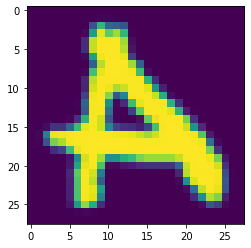

In [340]:
test_sample_idx = 9
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(tv.transforms.functional.hflip(test_image).reshape(28,28).rot90(k = 1).to('cpu'))
print(f"The original value of the sample is {emnist_map[int(emnist_test.targets[test_sample_idx])]}.")
#print("The digit shown is the value: {}".format(emnist_map[int(emnist_train.targets[idx])]))
#plt.imshow(tv.transforms.functional.hflip(img.rot90(k = 3)), cmap = 'gray')

It is possible to  classify this "clean" image using one of the models previously trained and then modify the image to attack the network. As an example, in this case the DBN with readout is going to be used. The predicted value for the sample is also shown.

In [341]:
attacked_model1 = ffnn
attacked_model = dbn_with_readout

In [342]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {emnist_map[int(prediction)]}.")

The prediction of the model for this clean sample is A.


The corresponding adversarial sample is now visualized. The single image is attacked with a perturbation of 0.2 allowed for each pixel.\\
Afterwards the new prediction is also given, and it seems, at least in this particular case, to be different from the original value. The attack was successful in misclassifying the input image.

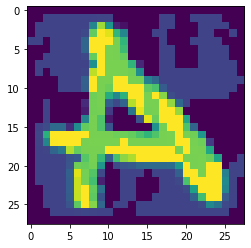

In [217]:
epsilon = 0.2 # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0) # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label) # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(np.rot90(perturbed_image_np.reshape(28,28), k = 3))

In [218]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {emnist_map[int(torch.argmax(model_outputs))]}.")

The prediction of the model for the perturbed sample is A.


The two models are now tested, to check their ability to resist adversarial attacks. The function iterates over the test data and for each sample generates a perturbed image, that needs to be classified. An accuracy is computed afterwards, that clearly show not so good results for the FFN, but decent results for the DBN, which is accurate in more than 50% of the cases.

In order to reduce the impact of the attack, a top-down reconstruction step is done, as a third case, on the DBN. This reconstruction goes from the hidden representation of the last layer, to the visible units and then back to the hidden representation again, for as many times as required (in this case only 1), removing from top to bottom all the perturbations that have been acquired.

The results show an improvement with the reconstruction in the accuracy, and also from visual inspection it is visible that the image is closer to what it was supposed to be originally.

In [281]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(np.flip(np.rot90(data[0].detach().to('cpu').numpy().reshape(28,28), k = 3), axis = 1))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(np.flip(np.rot90(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), k = 3), axis = 1))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                i = 0
                if i < 2: pass
                i += 1
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(np.flip(np.rot90(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28), k = 3), axis = 1))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [282]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', train=False, download=False, split = 'letters', transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

In [283]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 24.23%



In [284]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/208 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 53.45%



  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



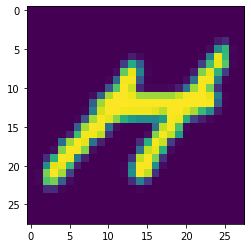


Here's a perturbed sample:



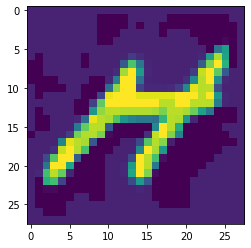


Here's what a 1-steps reconstructed sample looks like:



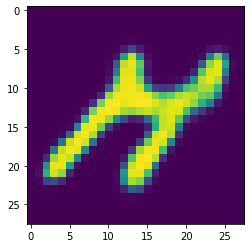


Epsilon: 0.1
Test Accuracy: 58.86%



In [285]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

Now the robustness of each one of the three models is tested, with an ever increasing strength of the attack. The FFN works definitely worse than the DBN, both when reconstructed and when left it. This clearly shows the greater accuracy of the DBN in this kind of problems, especially if it has the chance to reconstruct it. But either way, its performance is definititely better than what the FFN can do, since it obtains results even worse than the chance level for values of $\epsilon$ that reach a value of 0.20.

In [286]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [287]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

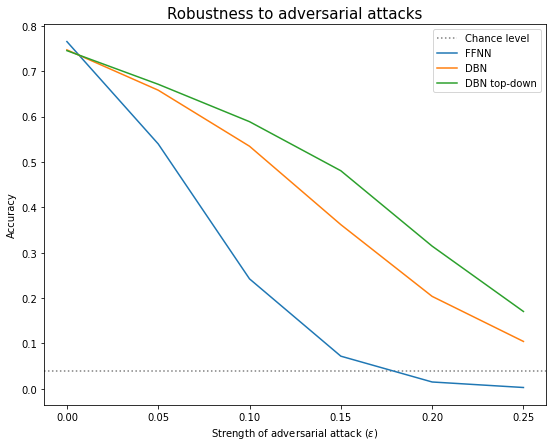

In [288]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.0385, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

## Conclusion

In the series of experiments that has been done in this notebook, it was shown what a DBN is able to do. Compared to a FFN it works way better in all the tests that were tried. This doesn't mean that the FFN is a bad model, but maybe it means that the DBN is a very good model when we are trying to simulate the perception of a human being. The small noise and the attacks that were applied on the images were no match for a human, who would be able to distinguish them with no problem. But for a neural network in general this is not so trivial, and it was proved that the DBN is a good candidate when we want to use an algorithm which is able to "simulate" in some way our perception.